<a href="https://colab.research.google.com/github/sravyapeesapati/DeepLearningAssignmets/blob/main/Satya_Sravya_Peesapati_HW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Step 1. Create your own custom dataset featuring 3 custom categories of at least 100 images each

Collection of images from Pixabay using API call and downloading them into locally which I am using for this assignment.

I am using images of dogs, cats and birds each 200 images

Step 2. Split this data between 80% training and 20% test

Step 3. Preprocess the data as you see fit

In [ ]:
import os
import shutil
import random  # Import the random module
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Set up the root directory of the dataset
root_dataset_path = '/content/drive/MyDrive/dataset'

# Ensure the paths for the classes are correct
for cls in ['birds', 'cats', 'dogs']:
    if not os.path.exists(os.path.join(root_dataset_path, cls)):
        raise ValueError(f"Directory for class '{cls}' does not exist.")

# Define your transformations
transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
])

# Function to create train and test directories and copy images
def prepare_data(root_dataset_path, dest_path, test_split=0.2):
    classes = ['birds', 'cats', 'dogs']
    for cls in classes:
        # Source directory for each class
        source_dir = os.path.join(root_dataset_path, cls)
        files = os.listdir(source_dir)
        # Shuffle files to ensure random distribution
        shuffled_files = random.sample(files, len(files))

        # Splitting files into train and test based on the specified test split ratio
        split_index = int(len(shuffled_files) * (1 - test_split))
        train_files = shuffled_files[:split_index]
        test_files = shuffled_files[split_index:]

        # Directories where the split dataset will be stored
        train_dir = os.path.join(dest_path, 'train', cls)
        test_dir = os.path.join(dest_path, 'test', cls)

        # Create directories if they don't exist
        os.makedirs(train_dir, exist_ok=True)
        os.makedirs(test_dir, exist_ok=True)

        # Copy images to the respective directories
        for f in train_files:
            shutil.copy2(os.path.join(source_dir, f), train_dir)
        for f in test_files:
            shutil.copy2(os.path.join(source_dir, f), test_dir)

# Call the function to prepare the data
dest_path = '/content/drive/MyDrive'  # Base destination path for the split dataset
prepare_data(root_dataset_path, dest_path)

# Now create the datasets and loaders from the new train/test folders
train_dataset = datasets.ImageFolder(os.path.join(dest_path, 'train'), transform=transform)
test_dataset = datasets.ImageFolder(os.path.join(dest_path, 'test'), transform=transform)

# Creating the DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Creation of acustom CNN model

Step 4. Create a Convolutional Neural Network model to learn about your training set.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class ImprovedCNN(nn.Module):
    def __init__(self):
        super(ImprovedCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(128 * 28 * 28, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 3),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


model = ImprovedCNN()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

Step 5. Make predictions on the test data and compare them to the expected categories

In [ ]:
import torch

def train_model(model, dataloaders, criterion, optimizer, num_epochs=50):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0


        for inputs, labels in dataloaders['train']:
            inputs, labels = inputs.to(device), labels.to(device)


            optimizer.zero_grad()


            outputs = model(inputs)
            loss = criterion(outputs, labels)


            loss.backward()
            optimizer.step()


            running_loss += loss.item()

        epoch_loss = running_loss / len(dataloaders['train'].dataset)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

    print('Training complete')

def evaluate_model(model, dataloaders, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloaders['test']:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy on the test set: {accuracy:.2f}%')


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

dataloaders = {
    'train': train_loader,
    'test': test_loader
}

train_model(model, dataloaders, criterion, optimizer, num_epochs=10)
evaluate_model(model, dataloaders, device)

Epoch 1/10, Loss: 0.7515
Epoch 2/10, Loss: 0.0527
Epoch 3/10, Loss: 0.0339
Epoch 4/10, Loss: 0.0330
Epoch 5/10, Loss: 0.0320
Epoch 6/10, Loss: 0.0311
Epoch 7/10, Loss: 0.0315
Epoch 8/10, Loss: 0.0310
Epoch 9/10, Loss: 0.0318
Epoch 10/10, Loss: 0.0300
Training complete
Accuracy on the test set: 50.00%


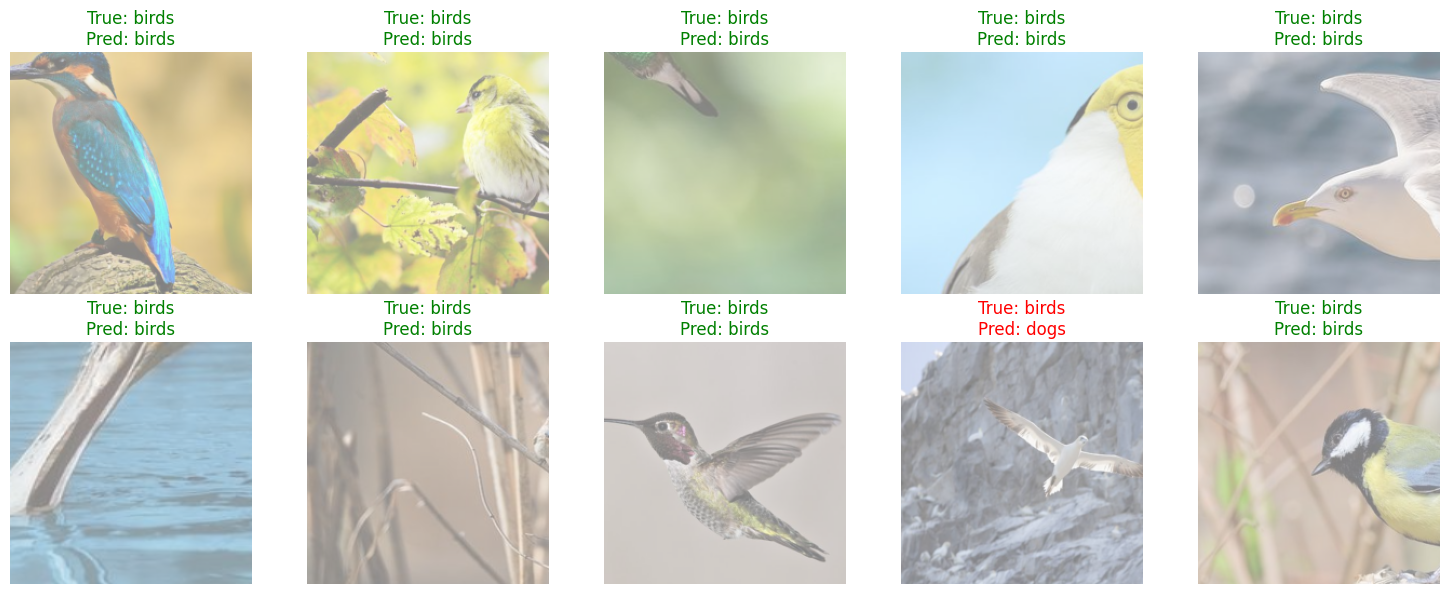

Displayed 9 correct and 1 incorrect examples out of 10 total displayed examples.


In [ ]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np

def visualize_predictions_with_labels(model, loader, class_names, num_images=10, images_per_row=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    fig, axes = plt.subplots(nrows=num_images // images_per_row, ncols=images_per_row, figsize=(15, 3 * (num_images // images_per_row)))
    if num_images // images_per_row == 1:
        axes = [axes]
    axes = axes.flatten()

    correct_examples = 0
    incorrect_examples = 0
    total_examples = 0

    with torch.no_grad():
        for data, targets in loader:
            if total_examples >= num_images:
                break
            data, targets = data.to(device), targets.to(device)
            outputs = model(data)
            _, preds = torch.max(outputs, 1)

            for i in range(len(targets)):
                if total_examples >= num_images:
                    break
                ax = axes[total_examples]
                img = data[i].cpu().numpy()
                img = np.transpose(img, (1, 2, 0))
                img = img / 2 + 0.5
                ax.imshow(img)
                ax.axis('off')

                if preds[i] == targets[i]:
                    ax.set_title(f'True: {class_names[targets[i]]}\nPred: {class_names[preds[i]]}', color='green')
                    correct_examples += 1
                else:
                    ax.set_title(f'True: {class_names[targets[i]]}\nPred: {class_names[preds[i]]}', color='red')
                    incorrect_examples += 1

                total_examples += 1

    plt.tight_layout()
    plt.show()
    print(f"Displayed {correct_examples} correct and {incorrect_examples} incorrect examples out of {total_examples} total displayed examples.")

class_names = ['birds', 'cats', 'dogs']

visualize_predictions_with_labels(model, test_loader, class_names, num_images=10, images_per_row=5)

Using Googlenet model

Step 6: Use GoogleNet(InceptionNet) and add a LinearLayer on top of it.

In [ ]:
import torch
import torch.nn as nn
from torchvision import models
import torch.optim as optim

# Load a pre-trained GoogLeNet model
googlenet = models.googlenet(pretrained=True)

# Freeze parameters to avoid backpropagation through them
for param in googlenet.parameters():
    param.requires_grad = False

# Adapt the final fully connected layer for 3 classes
num_ftrs = googlenet.fc.in_features
googlenet.fc = nn.Linear(num_ftrs, 3)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
googlenet.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 174MB/s]


GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

Step 7: Train the GoogleNet model and compare the accuracy with the first model.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader
import copy

def train_model(model, criterion, optimizer, dataloaders, num_epochs=25, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')):
    model.to(device)
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)


        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()


                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    print(f'Best val Acc: {best_acc:.4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(googlenet.fc.parameters(), lr=0.001)


model_ft = train_model(googlenet, criterion, optimizer, dataloaders, num_epochs=10, device=device)


Epoch 1/10
----------
Train Loss: 1.0144 Acc: 0.5021
Test Loss: 0.7951 Acc: 0.8000

Epoch 2/10
----------
Train Loss: 0.7154 Acc: 0.8312
Test Loss: 0.6059 Acc: 0.8583

Epoch 3/10
----------
Train Loss: 0.5613 Acc: 0.8667
Test Loss: 0.4849 Acc: 0.8583

Epoch 4/10
----------
Train Loss: 0.4686 Acc: 0.8729
Test Loss: 0.4660 Acc: 0.8750

Epoch 5/10
----------
Train Loss: 0.3977 Acc: 0.9062
Test Loss: 0.4137 Acc: 0.8917

Epoch 6/10
----------
Train Loss: 0.3646 Acc: 0.9042
Test Loss: 0.3380 Acc: 0.8917

Epoch 7/10
----------
Train Loss: 0.3710 Acc: 0.9021
Test Loss: 0.3592 Acc: 0.8500

Epoch 8/10
----------
Train Loss: 0.3613 Acc: 0.9000
Test Loss: 0.3223 Acc: 0.9250

Epoch 9/10
----------
Train Loss: 0.3348 Acc: 0.8937
Test Loss: 0.2990 Acc: 0.9167

Epoch 10/10
----------
Train Loss: 0.3353 Acc: 0.8917
Test Loss: 0.3627 Acc: 0.9250

Best val Acc: 0.9250


In [ ]:
def evaluate_model(model, dataloaders, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')):
    model.eval()
    model.to(device)
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloaders['test']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy: {accuracy:.2f}%')

evaluate_model(googlenet, dataloaders)

Accuracy: 90.83%


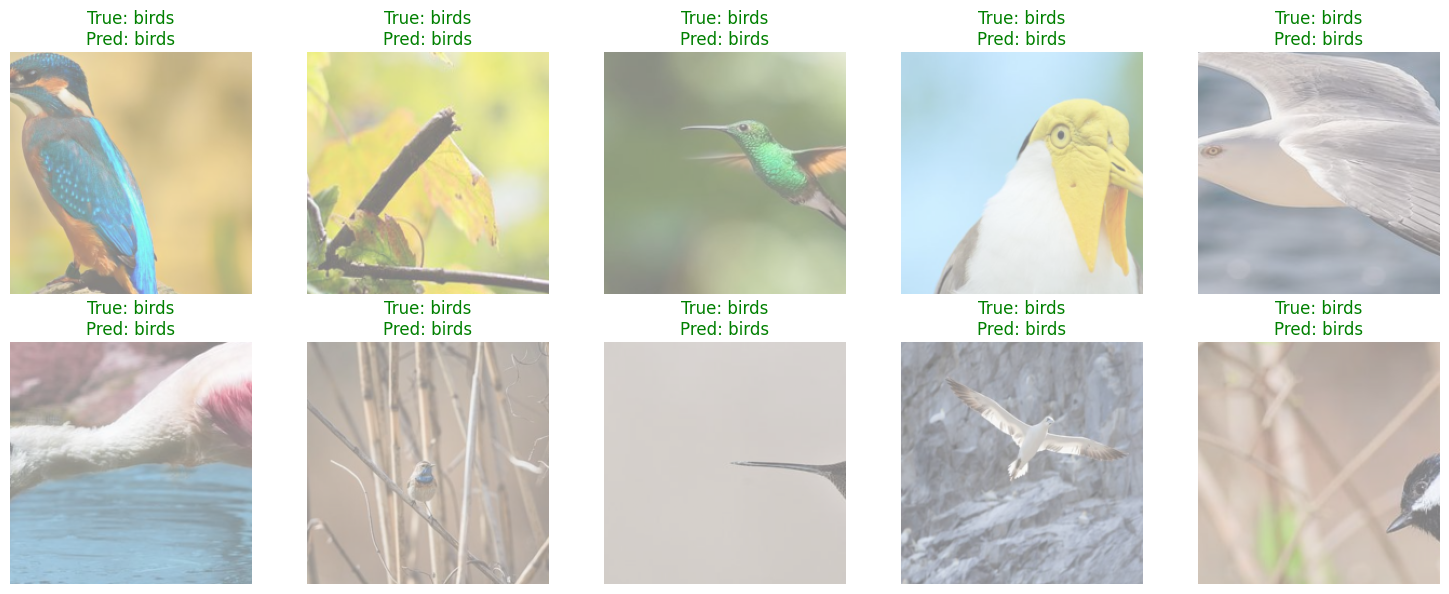

Displayed 10 correct and 0 incorrect examples out of 10 total displayed examples.


In [ ]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np

def visualize_predictions_with_labels(model, loader, class_names, num_images=10, images_per_row=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    fig, axes = plt.subplots(nrows=max(num_images // images_per_row, 1), ncols=images_per_row, figsize=(15, 3 * max(num_images // images_per_row, 1)))
    axes = axes.flatten() if num_images // images_per_row > 1 else [axes]

    correct_examples = 0
    incorrect_examples = 0
    total_examples = 0

    with torch.no_grad():
        for data, targets in loader:
            if total_examples >= num_images:
                break
            data, targets = data.to(device), targets.to(device)
            outputs = model(data)
            _, preds = torch.max(outputs, 1)

            for i in range(len(targets)):
                if total_examples >= num_images:
                    break
                ax = axes[total_examples]
                img = data[i].cpu().numpy()
                img = np.transpose(img, (1, 2, 0))
                img = img / 2 + 0.5
                ax.imshow(img)
                ax.axis('off')

                if preds[i] == targets[i]:
                    ax.set_title(f'True: {class_names[targets[i]]}\nPred: {class_names[preds[i]]}', color='green')
                    correct_examples += 1
                else:
                    ax.set_title(f'True: {class_names[targets[i]]}\nPred: {class_names[preds[i]]}', color='red')
                    incorrect_examples += 1

                total_examples += 1

    plt.tight_layout()
    plt.show()
    print(f"Displayed {correct_examples} correct and {incorrect_examples} incorrect examples out of {total_examples} total displayed examples.")

class_names = ['birds', 'cats', 'dogs']

test_loader = dataloaders['test']

visualize_predictions_with_labels(model_ft, test_loader, class_names, num_images=10, images_per_row=5)


Google net accuracy is higher while compared to the first model.

Increasing the training data will help in improving the model